<h1>Chapter10 "FAST"主动反射面的形状调节<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"></ul></div>

# 1. 预先检查
- <font color=white size=4 face=雅黑>读者可以通过以下代码检查所需要的库是否已经正确安装，若依赖的库未被正确安装，以下代码将会自动安装；</font>
- <font color=white size=4 face=雅黑>运行后如果依然显示库未被安装，可以尝试关闭代码窗口后重新打开；</font>

In [ ]:
!pip install tqdm
!pip install pandas
!pip install matplotlib
!pip install numpy
!pip install jax

In [28]:
import jax
import jax.numpy as jnp
import numpy as np

# 2. 类的导入

## 2.1 类型检查
- <font color=white size=4 face=雅黑>定义**常数**类 ScalorType, 作为程序输出应该为**常数**时的类型检查；</font>
- <font color=white size=4 face=雅黑>定义**长度**类 LengthType, 作为程序输出应该为**长度**时的类型检查；</font>

In [29]:
from typing import Union, List, Optional, Set

ScalorType = Union[float, np.ndarray, jnp.ndarray]
LengthType = Union[float, np.ndarray, jnp.ndarray]

## 2.2 Point类
- <font color=white size=4 face=雅黑>对应着三维空间之中的一个点，具有坐标 **(x,y,z)**,以及 **name**参数，具体定义如下；</font>
- <font color=white size=4 face=雅黑>如果两个`Point`类的 **name**相等，那么我们就认为这两个点是同一个点，这里**不会**对坐标是否相等进行另外检查；</font>
- <font color=white size=4 face=雅黑>如果 **p**是一个`Point`类的实例，则可以通过 **print(p)** 查看该点的信息；</font>

In [30]:
class Point(object):
    def __init__(self, x: Optional[ScalorType], 
                       y: Optional[ScalorType] = 0., 
                       z: Optional[ScalorType] = 0., 
                       name: str = None):
        self.x = x
        self.y = y
        self.z = z
        self.name = name

    def __eq__(self, other):
        # 如果 P1 和 P2 都是 Point类，且名称（也就是name参数）相同，我们就认为两个点是相同的， 
        #     ———— 也就是说 P1 == P2 将会返回 True
        if type(self) != type(other): return False
        return self.name == other.name
    
    def __str__(self):
        # 指定调用print函数时，程序终端将会输出的string
        return "class Point:\n\t name = {} \n\t position = ({}, {}, {})".format(self.name, self.x, self.y, self.z)
    
    @property
    def position(self):
        return (self.x, self.y, self.z)

Point类测试

In [31]:
Origin = Point(0., 0., 0., name="Origin")
print(Origin)

class Point:
	 name = Origin 
	 position = (0.0, 0.0, 0.0)


## 2.3 Vertex类
- <font color=white size=4 face=雅黑>`Vertex`类继承自`Point`类，但不同的是，`Point`类代表**空间**之中的一个**点**，而`Vertex`类代表的是**图**上的一个**顶点**；相比于其父类`Point`，`Vertex`类增加了近邻节点的信息，用一个列表**self.adjacent**储存图上近邻的顶点(的指针)</font>
- <font color=white size=4 face=雅黑>如果 **v**是一个`Vertex`类的实例，则可以通过 **print(v)** 查看该点的信息；</font>
- <font color=white size=4 face=雅黑>如果两个`Vertex`类的 **name**相等，那么我们就认为这两个顶点是同一个点，这里**会对**坐标是否相等进行另外检查；</font>
- <font color=white size=4 face=雅黑>`VertexInfo`类用于储存有关于`Vertex`的信息，在这里，信息包括：</font>

  - <font color=white size=3.5 face=雅黑>self.idx   : 顶点在主索节点列表之中的位置</font>
  - <font color=white size=3.5 face=雅黑>self.status: 顶点目前所在的状态</font>
  - <font color=white size=3.5 face=雅黑>self.vertex_init_pos  : 顶点的初始位置</font>
  - <font color=white size=3.5 face=雅黑>self.vertex_ground_pos: 顶点对应固定在地面上的促动器的坐标 </font>

In [32]:
class VertexInfo(object):
    def __init__(self, index:int = -1,
                       status: int = -1,
                       vertex_init_pos  :np.ndarray = None,
                       vertex_ground_pos:np.ndarray = None):
        self.idx: int = index     # 储存该顶点在输入 3xN 顶点列表之中的位置
        self._status: int = status # 描述该节点目前的状态, 0表示位于工作区，1表示位于工作区外（但不固定），2表示该节点固定
        self.vertex_init_pos  : np.ndarray = vertex_init_pos   # 顶点的初始位置
        self.vertex_ground_pos: np.ndarray = vertex_ground_pos # 固定在地面上的促动器的坐标 
    
    @property
    def status(self):
        if self._status == 0: return "working"
        if self._status == 1: return "idling"
        if self._status == 2: return "fixing"
        return "unsure"

In [33]:
import logging

class Vertex(Point):
    def __init__(self, name: str, 
                          x: ScalorType = None, 
                          y: ScalorType = None, 
                          z: ScalorType = None,
                          info:VertexInfo = None):
        super().__init__(x, y, z, name = name)  # 初始化顶点的名称及位置参数
        self.adjacent: List[Vertex] = []
        self.info : VertexInfo = info

    def __eq__(self, other):
        # 如果Vertex的名称(name参数)相同，我们就认为两个Vertex是一样的
        if type(self) != type(other): return False
        if self.name == other.name:
            # 如果两个顶点的名称相同，我们将会检查这两个节点的坐标和相邻节点是否相同
            # 如若不同，将会在终端产生warning, 但程序并不报错
            if self.x != other.x or self.y != other.y or self.z != other.z:
                logging.warning("Inconsistent position between Vertexes {}:\n"
                                "  [self]: {}\n [other]: {}".format(self.name, (self.x, self.y, self.z),
                                                                   (other.x, other.y, other.z)))
            if self.adjacent != other.adjacent:
                logging.warning("Inconsistent adjacent list between Vertex {}:\n"
                                " [self ]: {}\n [other]: {}".format(self.name, self.adjacent, other.adjacent))
            return True
        return False
    
    def __str__(self):
        # 指定调用print函数时，程序终端将会输出的string
        return "class Vertex:\n\tname: {}\n\tposition: {}\n\tadjacent vertex: {}".\
            format(self.name, (self.x, self.y, self.z), [_.name for _ in self.adjacent])
    
    def add_adjacent(self, vertex):
        # 向顶点的邻近表中添加节点
        assert type(self) == type(vertex)
        if vertex not in self.adjacent:
            self.adjacent.append(vertex)
            return True
        return False

    @property
    def n_adjacent(self):
        return len(self.adjacent)

## 2.4 Edge类
- <font color=white size=4 face=雅黑>对应着图上的一条无向边，存有`Edge`的两个顶点,**name**参数为两个顶点对应**name**参数构成的Set；</font>
- <font color=white size=4 face=雅黑>如果两个Edge类的 **name**相等，那么我们就认为这两条边相等，这里**不考虑**`Edge`当中顶点的先后顺序；</font>
- <font color=white size=4 face=雅黑>如果 **e**是一个`Edge`类的实例，则可以通过 **print(e)** 查看该条边的信息；</font>

In [34]:
class Edge(object):
    def __init__(self, v1: Vertex, v2: Vertex):
        self.v1 = v1
        self.v2 = v2
        self.name: Set = {v1.name, v2.name}
        self.length_init = self.length

    def __eq__(self, other):
        if type(self) != type(other): return False
        return self.name == other.name

    def __str__(self):
        return "class Edge: \n\t name = {} \n\t v1.position = {} \n\t v2.position = {} \n\t length = {}".\
        format(self.name, self.v1.position, self.v2.position, self.length)

    @property
    def length(self) -> LengthType:
        # the length of the edge
        return ((self.v1.x - self.v2.x) ** 2 + (self.v1.y - self.v2.y) ** 2 + (self.v1.z - self.v2.z) ** 2) ** 0.5

Edge类的测试

In [35]:
e0 = Edge(Origin, Origin)
print(e0)

class Edge: 
	 name = {'Origin'} 
	 v1.position = (0.0, 0.0, 0.0) 
	 v2.position = (0.0, 0.0, 0.0) 
	 length = 0.0


## 2.5 Graph类
- <font color=white size=4 face=雅黑>可以直接输入边和顶点的列表，也可以通过顶点的列表构造出边；</font>

In [36]:
class Graph(object):
    def __init__(self, vertex_list: Optional[List[Vertex]]=[], 
                       edge_list  : Optional[List[Edge  ]]=[]):
        self.vertex_list: List[Vertex] = vertex_list
        self.edge_list  : List[Edge  ] = [] if edge_list == None else edge_list

    def update_edge(self):
        logging.info("Updating Edges...")
        from tqdm import tqdm
        for v in tqdm(self.vertex_list):
            for v_adjacent in v.adjacent:
                assert v in v_adjacent.adjacent
                edge = Edge(v, v_adjacent)
                if edge not in self.edge_list:
                    self.edge_list.append(edge)
    
    @property
    def n_edge(self):
        return len(self.edge_list)

    @property
    def n_vertex(self):
        return len(self.vertex_list)

# 3. 数据的读入

## 3.1 从csv文件读入数据，储存在pandas.DataFrame之中，留作备份

In [37]:
import pandas as pd

vertex_frame = pd.read_csv('./data/vertex.csv',header=0,sep=',')
ground_vertex_frame = pd.read_csv('./data/vertex_ground.csv',header=0,sep=',')
face_vertex_frame = pd.read_csv('./data/face.csv',header=0,sep=',')

In [38]:
vertex_frame.head()

,Index,X,Y,Z
0,A0,0.0000,0.000,-300.4000
1,B1,6.1078,8.407,-300.2202
2,C1,9.8827,-3.211,-300.2202
3,D1,0.0000,-10.391,-300.2202
4,E1,-9.8827,-3.211,-300.2202


In [39]:
ground_vertex_frame.head()

,Index,Xg,Yg,Zg
0,A0,0.0000,0.000,-304.7218
1,B1,6.1935,8.525,-304.4318
2,C1,10.0227,-3.256,-304.4747
3,D1,0.0000,-10.538,-304.4868
4,E1,-10.0214,-3.256,-304.4337


In [40]:
face_vertex_frame.head()

,Index1,Index2,Index3
0,A0,B1,C1
1,A0,B1,A1
2,A0,C1,D1
3,A0,D1,E1
4,A0,E1,A1


In [41]:
isinstance(face_vertex_frame, pd.DataFrame)

True

## 3.2 从pandas.DataFrame之中读出数据，构建出图的网络结构

### 3.2.1 读取顶点（主索节点）列表 vertex_frame, 促动器列表 ground_vertex_frame 的数据

In [42]:
from tqdm import tqdm
vertex_list: List[Vertex] = []
print("Getting Information...")
for idx in tqdm(range(len(vertex_frame))):
    # 获取主索节点的位置信息
    vx = vertex_frame["X"][idx]
    vy = vertex_frame["Y"][idx]
    vz = vertex_frame["Z"][idx]
    init_v_pos = np.array([vx, vy, vz], dtype=np.float64)
    # 获取主索节点促动器固定处位置的信息
    assert vertex_frame["Index"][idx] == ground_vertex_frame["Index"][idx]
    gvx = ground_vertex_frame["Xg"][idx]
    gvy = ground_vertex_frame["Yg"][idx]
    gvz = ground_vertex_frame["Zg"][idx]
    gv_pos = np.array([gvx, gvy, gvz], dtype=np.float64)
    vertex_info = VertexInfo(index = idx, status=-1, 
                             vertex_init_pos   =init_v_pos,
                             vertex_ground_pos =gv_pos)
    vertex_list.append(Vertex(name=vertex_frame["Index"][idx],
                              x=vx,
                              y=vy,
                              z=vz,
                              info=vertex_info))

print("len(vertex_list) = ", len(vertex_list))

Getting Information...


100%|██████████| 2226/2226 [00:00<00:00, 12963.01it/s]

len(vertex_list) =  2226


### 3.2.2 通过 face_vertex_frame 更新顶点之间的近邻关系

In [43]:
print("updating adjacent relationships...")
for face_idx in tqdm(range(len(face_vertex_frame))):
    # 读取三角反射面三个顶点的 name 参数
    v1_name = face_vertex_frame["Index1"][face_idx]
    v2_name = face_vertex_frame["Index2"][face_idx]
    v3_name = face_vertex_frame["Index3"][face_idx]
    # 在 vertex_list 之中根据 name参数 找到相应的顶点，
    v1, v2, v3 = None, None, None
    for v in vertex_list:
        if v.name == v1_name: v1 = v
        if v.name == v2_name: v2 = v
        if v.name == v3_name: v3 = v
        if v1 and v2 and v3: break
    
    # 更新近邻节点的信息
    assert v1 and v2 and v3
    v1.add_adjacent(v2)
    v1.add_adjacent(v3)
    v2.add_adjacent(v3)
    v2.add_adjacent(v1)
    v3.add_adjacent(v1)
    v3.add_adjacent(v2)

updating adjacent relationships...


100%|██████████| 4300/4300 [00:01<00:00, 2728.49it/s]


### 3.2.3 构造图

In [44]:
FASTnet = Graph(vertex_list = vertex_list)
FASTnet.update_edge()
print("n_edge   = ", FASTnet.n_edge)
print("n_vertex = ", FASTnet.n_vertex)

100%|██████████| 2226/2226 [00:10<00:00, 213.45it/s]

n_edge   =  6525
n_vertex =  2226


## 3.3 图的测试

In [45]:
for i in range(2):
    print(FASTnet.vertex_list[i])
    print(FASTnet.edge_list[i])

class Vertex:
	name: A0
	position: (0.0, 0.0, -300.4)
	adjacent vertex: ['B1', 'C1', 'A1', 'D1', 'E1']
class Edge: 
	 name = {'A0', 'B1'} 
	 v1.position = (0.0, 0.0, -300.4) 
	 v2.position = (6.1078, 8.407, -300.2202) 
	 length = 10.393036028033388
class Vertex:
	name: B1
	position: (6.1078, 8.407, -300.2202)
	adjacent vertex: ['C1', 'A0', 'A1', 'B3', 'A3', 'B2']
class Edge: 
	 name = {'A0', 'C1'} 
	 v1.position = (0.0, 0.0, -300.4) 
	 v2.position = (9.8827, -3.211, -300.2202) 
	 length = 10.392815226395589


# 4. 能量计算函数的得到

## 4.1 判断节点是否处于工作区，分别储存

In [46]:
def isworking(x:ScalorType,y:ScalorType,z:ScalorType):
    return (x ** 2 + y ** 2) < 150**2

In [47]:
vertex_list_working : List[Vertex] = []
vertex_list_fixing : List[Vertex]  = []
vertex_list_idling : List[Vertex]  = []
for i, vertex in enumerate(FASTnet.vertex_list):
    if isworking(*vertex.info.vertex_init_pos):
        vertex.info._status=0
        vertex_list_working.append(vertex)
    elif vertex.n_adjacent < 5:
        vertex.info._status=2
        vertex_list_fixing.append(vertex)
    else:
        vertex.info._status=1
        vertex_list_idling.append(vertex)

print(len(vertex_list_working))
print(len(vertex_list_fixing))
print(len(vertex_list_idling))

706
130
1390


<font color=white size=4 face=雅黑>测试</font>

In [48]:
print(vertex_list_working[0].info.status)
print(vertex_list_fixing[0].info.status)
print(vertex_list_idling[0].info.status)

working
fixing
idling


## 4.2 定义单根连接索的能量

In [54]:
# 超参数

k_timer = 1.
offset_ratio = 7E-4

# 参数
D = 30E-3              # 直径（米）
A = D**2 * 3.1415 / 4  # 横截面积（米^2）
E = 1.8E11             # 杨氏模量（Pa）
c1 = E * A

def edge_energy(length:LengthType, length_init:LengthType):
    delta_L = jnp.abs(length - length_init)
    lc = offset_ratio * length_init
    K = c1 / lc
    if delta_L < lc:
        return 0.5 * K * delta_L ** 2
    else:
        return 0.5 * K * lc ** 2 + k_timer * K * (delta_L - lc) * lc

<font color=white size=4 face=雅黑>可视化</font>

Text(0, 0.5, 'energy')

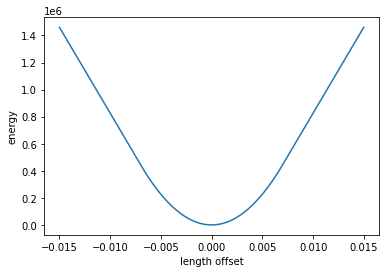

In [55]:
import matplotlib.pyplot as plt

length_init_test  = 10.
length_max_offset_test = length_init_test * offset_ratio * 2.14
length_delta_test = jnp.linspace(-length_max_offset_test, length_max_offset_test, 1001)
energy = []
for dl in length_delta_test:
    e = edge_energy(length_init_test+dl, length_init_test)
    energy.append(e)


plt.plot(length_delta_test, energy)
plt.xlabel("length offset")
plt.ylabel("energy")

## 4.3 确定目标抛物面的形状
- <font color=white size=4 face=雅黑>此处未经证明</font>

In [ ]:
def calc_z(x, y, h=300.89097588, R=300.4):
    return (x**2+y**2) / (4*(h-R+0.466*R))-h

## 4.4 无约束条件下的能量函数

In [72]:
pos_list = jnp.array(vertex_frame.iloc[:,1:])

In [76]:
def gen_net_energy(net: Graph):
    adjacent_idx1 = [e.v1.info.idx for e in net.edge_list]
    adjacent_idx2 = [e.v2.info.idx for e in net.edge_list]
    # print(len(adjacent_idx1))
    # print(adjacent_idx1[:20])
    # print(adjacent_idx2[:20])

    def net_energy(pos_array: jnp.ndarray):
        # pos_array 的 shape 是 (N, 3)
        print(pos_array[[adjacent_idx1]])
        return 0
    return net_energy

net_energy = gen_net_energy(FASTnet)
e = net_energy(pos_list)

TypeError: Using a non-tuple sequence for multidimensional indexing is not allowed; use `arr[tuple(seq)]` instead of `arr[seq]`. See https://github.com/google/jax/issues/4564 for more information.

DeviceArray([[   0.    ,    0.    , -300.4   ],
             [   6.1078,    8.407 , -300.2202],
             [   9.8827,   -3.211 , -300.2202],
             ...,
             [-181.2632,  165.587 , -173.1041],
             [-175.262 ,  173.878 , -171.1434],
             [-168.969 ,  181.996 , -169.0189]], dtype=float32)

# Start calculating!

## initialization

In [ ]:
for v in vertex_list_working:
    v.z = calc_z(v.x, v.y)

In [ ]:
!pip install openpyxl